In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tools import plot_perf,plot_results,store_hist,add_noise,scale

In [3]:
# Importing data
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')

y = df_train['label']     
X = df_train.drop('label',axis=1)

In [4]:
def scale(data):
    # Scaling the data to be between 0 and 1 since the images we're going to be working with will be grey scale
    scaled_data = data/np.max(data.values)
    return scaled_data

In [7]:
def add_noise(data, noise_level):
    """Adding gaussian noise to the data
        Inputs: list of arrays of data
                noise level of gaussian noise you want added"""
    noise = noise_level*np.random.normal(loc=0,scale=1.0,size=data.shape)
    data = data + noise

    data = np.clip(data,0,1)

    return data,noise

In [5]:
# Scaling data
X = scale(X)
# Reshaping data
X = X.values.reshape(-1,28,28,1)

In [6]:
def plot(data,start=0,save=False):
    """Input: a list of variables containing MNIST data to plot
              what number in the data you want to start at"""
    
    n = 10
    if start == None:
        start=0
    plt.figure(figsize=(20,len(data)*2))
    # Looping over datasets to compare
    for j in range(len(data)):
        # Looping over numbers in each dataset
        for i in range(start,start+n):
             loc = i-start
             ax = plt.subplot(len(data),n,loc+1+(j*n))
             plt.imshow(data[j][i])
             plt.gray()
             ax.get_xaxis().set_visible(False)
             ax.get_yaxis().set_visible(False)

    if save:
        file_name = input("file name:")
        plt.savefig('./results/images/%s_start%s.png'%(file_name,start))

In [10]:
def add_model(global_hist,recent_hist,name): 
    """ Input :     Overall history for all models (dataframe)
                    recent model run history (dataframe)
                    name for most recent model (string)
        Output:     Overall history for all models (dataframe) 

    """
    # Removing previous run of this model from model_hist
    global_hist = global_hist[global_hist.model != name]
    recent_hist["model"] = name
    global_hist = pd.concat([global_hist,recent_hist],axis=0)

    return global_hist

In [11]:
# Creating a function to efficiently plot and compare the different models I'm testing
def plot_hist(hist,models,metrics):
    """
    Input: 
        models - list of strings of which models you want to compare, default is all
        metrics - list of strings of which metrics you want to compare"""

    # If empty list passed, all models are compared
    if len(models) == 0: 
        models=list(hist["model"].unique())   
    plt.figure(figsize=(12,6))
    # Looping through all models and metrics and plotting them on the graph with appropriate labels
    for model in models:
        for m in metrics:
            y_plt = hist[(hist["model"]==model)][m].values
            x_plt = range(0,len(y_plt))
            plt.plot(x_plt,y_plt,linewidth=3,label=model+' ('+m+')')
    plt.xlabel('Epochs')
    plt.ylabel(m)
    plt.legend()

In [106]:
from ModelGen import autoencoder

In [107]:
model = autoencoder('Unet')

In [78]:
X_noisy, noise = add_noise(X,noise_level=0.5)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_samp = X[0:10000]
X_noisy_samp = X_noisy[0:10000]

In [47]:
X_train_noisy, X_test_noisy ,X_train, X_test = train_test_split(X_noisy_samp,X_samp,test_size=0.2,random_state=101)

In [48]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.02,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [62]:
modelTr2 = AutoEncoderModelTr()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 22, 22, 32)        4640      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 20, 20, 128)       36992     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 18, 18, 256)       295168    
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 20, 20, 256)       590080    
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 22, 22, 128)      

In [50]:
modelUpSc = AutoEncoderModel()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 8)          

In [51]:
modelUnet = AutoEncoderModelUnet(X_noisy,start_filters=8)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 28, 28, 8)    80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 28, 28, 8)    584         conv2d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 14, 14, 8)    0           conv2d_34[0][0]                  
_______________________________________________________________________________________

In [69]:
epochs = 15
batch_size = 256

In [70]:
# history = modelUpSc.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs,shuffle=True,
#                     validation_data =(X_test_noisy,X_test),callbacks=callback,use_multiprocessing=True)

In [71]:
historyTr2 = modelTr2.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs,shuffle=True,
                     validation_data =(X_test_noisy,X_test),callbacks=callback,use_multiprocessing=True)

Epoch 1/15
32/32 [==============================] - 259s 8s/step - loss: 0.1000 - val_loss: 0.0996
Epoch 2/15
32/32 [==============================] - 263s 8s/step - loss: 0.0990 - val_loss: 0.0992
Epoch 3/15
32/32 [==============================] - 268s 8s/step - loss: 0.0987 - val_loss: 0.0991
Epoch 4/15
32/32 [==============================] - 262s 8s/step - loss: 0.0976 - val_loss: 0.0977
Epoch 5/15
32/32 [==============================] - 260s 8s/step - loss: 0.0968 - val_loss: 0.0974
Epoch 6/15
32/32 [==============================] - 258s 8s/step - loss: 0.0967 - val_loss: 0.0969


In [55]:
epochs = 5
batch_size = 128

In [56]:
historyUnet = modelUnet.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs,shuffle=True,
                    validation_data =(X_test_noisy,X_test),callbacks=callback,use_multiprocessing=True)

Epoch 1/5
63/63 [==============================] - 29s 466ms/step - loss: 0.4835 - val_loss: 0.2730
Epoch 2/5
63/63 [==============================] - 29s 464ms/step - loss: 0.1966 - val_loss: 0.1306
Epoch 3/5
63/63 [==============================] - 30s 479ms/step - loss: 0.1272 - val_loss: 0.1146
Epoch 4/5
63/63 [==============================] - 27s 426ms/step - loss: 0.1176 - val_loss: 0.1088
Epoch 5/5
63/63 [==============================] - 25s 391ms/step - loss: 0.1134 - val_loss: 0.1060


In [177]:
decoded_img = modelUpSc.predict(X_test)

In [76]:
decoded_imgTr = modelTr.predict(X_test_noisy[0:10])
decoded_imgTr2 = modelTr2.predict(X_test_noisy[0:10])

In [57]:
decoded_imgUnet = modelUnet.predict(X_test_noisy)

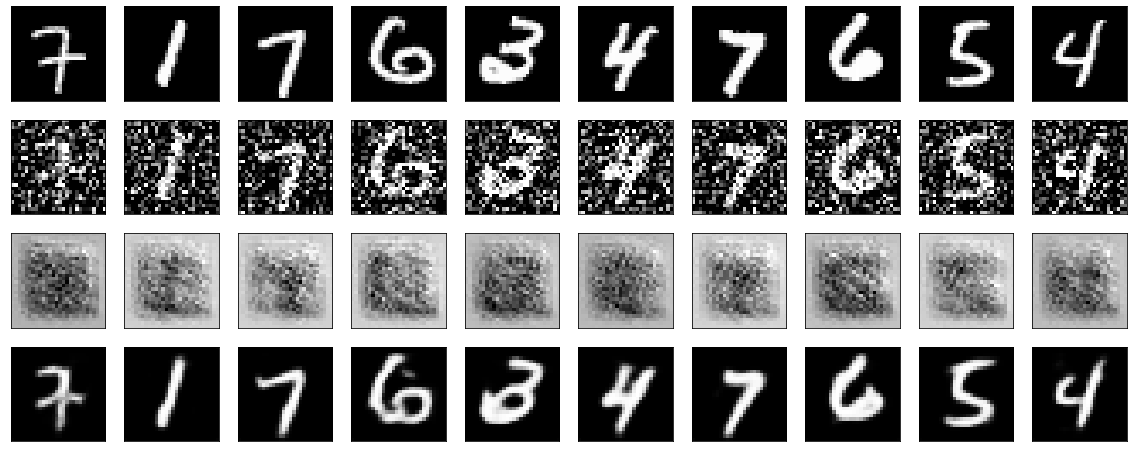

In [77]:
plot([X_test,X_test_noisy,decoded_imgTr,decoded_imgTr2])

In [190]:
historyTr = pd.DataFrame(historyTr.history)
historyTr["model"] = 'Tr0.6'
hist = pd.DataFrame(history.history)
hist["model"]='UpSc0.6'

AttributeError: 'DataFrame' object has no attribute 'history'

In [191]:
model_hist = add_model(hist,historyTr,name='Tr0.6')

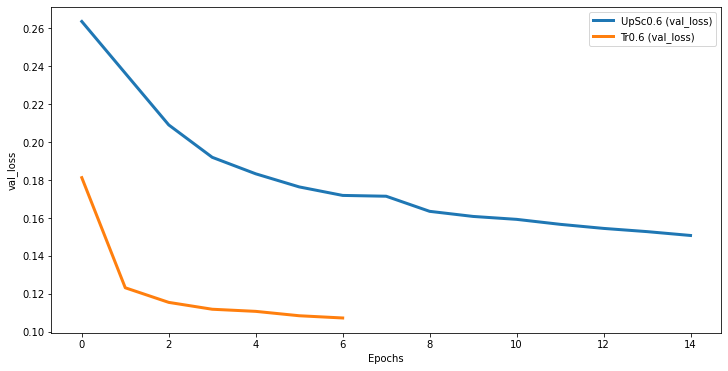

In [192]:
plot_hist(model_hist,models=['UpSc0.6','Tr0.6'],metrics=['val_loss'])

In [183]:
from tensorflow.keras.utils import plot_model

In [184]:
#img_file = './tmp/model_UpSc.png'
#img_file2 = './tmp/model_Tr.png'

In [185]:
#plot_model(model, to_file=img_file,show_shapes=True)
#plot_model(modelTr, to_file=img_file2,show_shapes=True)

In [197]:
modelUpSc.save('./models/model_UpSc0.6')
modelTr.save('./models/model_Tr0.6')

INFO:tensorflow:Assets written to: ./models/model_UpSc0.6/assets
INFO:tensorflow:Assets written to: ./models/model_UpSc0.6/assets
INFO:tensorflow:Assets written to: ./models/model_Tr0.6/assets
INFO:tensorflow:Assets written to: ./models/model_Tr0.6/assets


In [35]:
from tensorflow.keras.models import load_model

In [36]:
modelUpSc02 = load_model('./models/model_UpSc')
modelUpSc06 = load_model('./models/model_UpSc0.6')
modelTr02 = load_model('./models/model_Tr')
modelTr06 = load_model('./models/model_Tr0.6')

In [37]:
X_noisy02, noise = add_noise(X,noise_level=0.2)
X_noisy06, noise = add_noise(X,noise_level=0.6)

In [38]:
denoise06_w_m02 = modelTr02.predict(X_noisy06[0:10])
denoise02_w_m06 = modelTr06.predict(X_noisy02[0:10])
denoise02_w_m02 = modelTr02.predict(X_noisy02[0:10])
denoise06_w_m06 = modelTr06.predict(X_noisy06[0:10])
# denoise06_w_m06Unet = modelTr06.predict(X_noisy06[0:10])

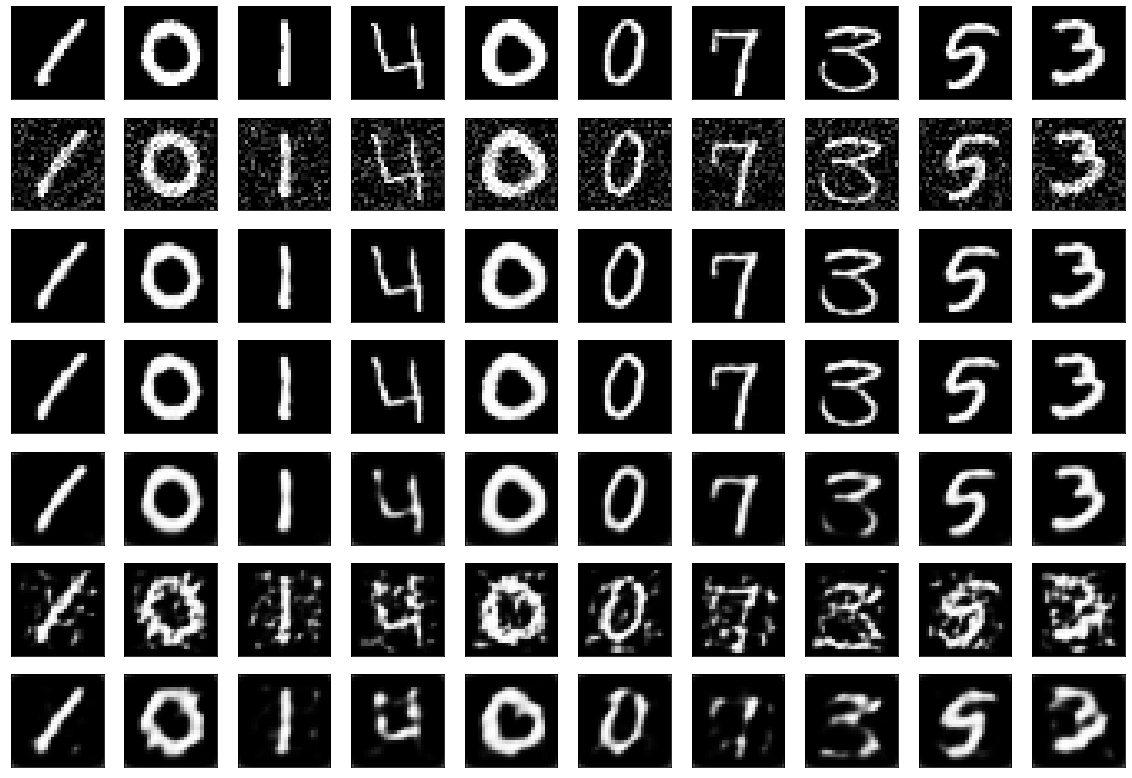

In [43]:
plot([X[0:10],X_noisy02,denoise02_w_m02,denoise02_w_m02,denoise02_w_m06,denoise06_w_m02,denoise06_w_m06])

In [224]:
diff_n06_m06 = X[0:10]-denoise06_w_m06

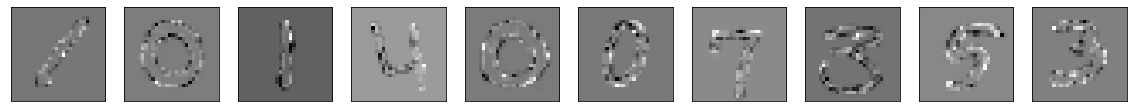

In [225]:
plot([diff_n06_m06])